In [1]:
import numpy as np
import os
import shutil
from datetime import datetime
import pandas as pd
from glob import glob
import xarray as xr
import netCDF4

from setup_parameters import setup_Ks
from generate_parameters import generate_Ks
from run_realization import setup_submit_wait
from DA_operators import operator_clm_SMAP

from settings import settings_run,settings_clm,settings_pfl,settings_sbatch, date_results_binned

from multiprocessing import Pool
from itertools import repeat
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [4]:
settings_pfl

{'t_dump': Timedelta('3 days 00:00:00'),
 't_couple': datetime.timedelta(seconds=900),
 'nx': 111,
 'ny': 108,
 'dx': '50000.0',
 'dy': '50000.0',
 'n_proc_pfl_x': 6,
 'n_proc_pfl_y': 6,
 'n_proc_pfl_z': 1,
 'IC_file': '/p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/tsmp_cordex_spinup_111x108/run_009_20090101-20100101/cordex111x108_20090101-20100101.out.00011.nc'}

In [13]:
def realize_parameters(i_real,settings_gen,settings_run,init=True):
    print('Creating parameter realizations for ensemble member %i' % i_real)
    dir_real = os.path.join(settings_run['dir_iter'],'R%3.3i'%i_real)
    local_state = np.random.RandomState() #required for parallel processes in python
    dir_DA = settings_run['dir_DA']

    if not os.path.exists(dir_real):
        print('Creating folder for realization %i: %s' % (i_real,dir_real), flush=True )
        os.mkdir(dir_real)

        if init:
            print('Initializing parameters from prior parameter settings')

            # Read parameter values + std, generate parameter realizations (i_real)
            for p_name, p_fn_gen in zip(settings_gen['param_names'],settings_gen['param_gen']):
                p_values = np.load(os.path.join(dir_DA,'%s.param.%3.3i.%3.3i.prior.npy'% (p_name,settings_gen['i_date'],settings_gen['i_iter']) ))
                p_mean = p_values[:,0]
                p_sigma = p_values[:,1]
                
                # ensemble member 0: most likely parameter values are used
                if i_real == 0:
                    p_real = p_mean.copy()
                else:
                    p_real = local_state.normal(p_mean,p_sigma)
                np.save(os.path.join(dir_DA,'%s.param.%3.3i.%3.3i.%3.3i'%(p_name,settings_gen['i_date'],settings_gen['i_iter'],i_real)),p_real)
                p_fn_gen(i_real,settings_gen,settings_run)
        else:
            print('Updating parameters from DA analysis')
            for p_name, p_fn_gen in zip(settings_gen['param_names'],settings_gen['param_gen']):
                p_fn_gen(i_real,settings_gen,settings_run)
        
        
def read_parameters(n_ensemble,settings_gen,settings_run):
    # read parameter values of the different ensemble members into an array
    for i1 in np.arange(n_ensemble):
        param_tmp = np.array([])
        
        if i1 == 0:
            for i2,p_name in enumerate(settings_gen['param_names']):
                param_ = np.load(os.path.join(settings_run['dir_DA'],'%s.param.%3.3i.%3.3i.%3.3i.npy'% (p_name,settings_gen['i_date'],settings_gen['i_iter'],i1+1) ))
                settings_gen['param_length'][p_name] = len(param_)
                param_tmp = np.append(param_tmp,param_)
            param_all = param_tmp.copy()
    
        else:
            for i2,p_name in enumerate(settings_gen['param_names']):
                param_ = np.load(os.path.join(settings_run['dir_DA'],'%s.param.%3.3i.%3.3i.%3.3i.npy'% (p_name,settings_gen['i_date'],settings_gen['i_iter'],i1+1) ))
                param_tmp = np.append(param_tmp,param_)        
            param_all = np.vstack((param_all,param_tmp))
    return param_all.T 

def write_parameters(parameters,settings_gen,settings_run):
    dir_DA = settings_run['dir_DA']
    for i_real in range(parameters.shape[1]):
        i_start = 0
        for p_name in settings_gen['param_names']:
            i_end = i_start + settings_gen['param_length'][p_name] + 1
            param_ = parameters[i_start:i_end,i_real]
            np.save(os.path.join(dir_DA,'%s.param.%3.3i.%3.3i.%3.3i'%(p_name,settings_gen['i_date'],settings_gen['i_iter']+1,i_real+1)),param_)
            i_start = i_end
            
    # write mean parameter values to member 0
    i_start = 0
    for p_name in settings_gen['param_names']:
        i_end = i_start + settings_gen['param_length'][p_name] + 1
        param_ = parameters[i_start:i_end,:].mean(axis=1)
        np.save(os.path.join(dir_DA,'%s.param.%3.3i.%3.3i.%3.3i'%(p_name,settings_gen['i_date'],settings_gen['i_iter']+1,0)),param_)
        i_start = i_end   
        
def plot_results(operator,settings_gen,settings_run):

    for date_ in operator.data_TSMP_ml.keys():

        str_date = str(date_.date())
        
        min_ = min(min(operator.data_TSMP_ml[date_]),min(operator.sm_out[date_]))
        max_ = max(max(operator.data_TSMP_ml[date_]),max(operator.sm_out[date_]))
        R = pearsonr(operator.data_TSMP_ml[date_],operator.sm_out[date_])[0]
        plt.figure(figsize=(5,5))
        plt.plot(operator.data_TSMP_ml[date_],operator.sm_out[date_],'o',alpha=.7,markersize=3)
        plt.plot([min_,max_],[min_,max_],'k:')
        plt.xlabel('Modelled soil moisture')
        plt.ylabel('SMAP soil moisture')
        plt.title('%s, R=%3.3f (mean param. values)' % (date_,R) )
        plt.savefig(os.path.join(settings_run['dir_figs'],'corr_%s_%3.3i.png'%(str_date,settings_gen['i_iter']) ) )

        plt.figure()
        plt.pcolormesh(operator.grid_TSMP['lon_corner'],operator.grid_TSMP['lat_corner'],operator.grid_TSMP['lsm']==2,cmap=plt.cm.Greys,vmax=2 )
        diff = operator.sm_out[date_] - operator.data_TSMP_ml[date_]
        diff_max = max(np.abs(diff))
        plt.scatter(operator.lons_out[date_],operator.lats_out[date_],s=10,c=diff,vmin=-diff_max,vmax=diff_max,cmap=plt.cm.bwr)
        cbar = plt.colorbar()
        cbar.set_label('SMAP - TSMP (mean param. values)')
        plt.savefig(os.path.join(settings_run['dir_figs'],'mismatch_%s_%3.3i.png'%(str_date,settings_gen['i_iter']) ) )


In [9]:
parameters = np.random.rand(10,3)
parameters[1:9,:].mean(axis=1).shape

(8,)

In [17]:
# Functions that are run to initialize the parameters to be assimilated. 
# E.g. for spatial parameter fields, initialize the static fields (x,y,z) locations and the prior/uncertainty estimates
param_setup = [setup_Ks]
# Functions that are run to generate realizations of parameters/state variables
param_gen   = [generate_Ks]
# Define parameter names; parameters values are stored in (%s.param.npy % param_name) files
param_names = ['Ks']
# Length of parameter arrays; calculated on the fly
param_length = {}

data_names = ['SMAP']
data_var = [0.05**2]

run_parallel = True #run the DA (e.g. creating realizations) in parallel if possible
n_parallel = 5 # set to n_ensemble+1 for all runs to run simultaneously (member 0 = most likely params)
n_ensemble = 4
n_iter = 1
nx = 111 #111,222,444
ny = 108 #108,216,432

dir_setup = '/p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/DA_tsmp_cordex_%ix%i' % (nx,ny)
dir_template = '/p/project/cjibg36/kaandorp2/TSMP_setups/setup_DA_tsmp_cordex_%ix%i/' % (nx,ny)

file_indi = os.path.join(dir_template,'input_pf/EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_111x108_INDICATOR_regridded_rescaled_SoilGrids250-v2017_BGR3_alv.sa')

# settings required for the functions in setup_parameters and generate_parameters
settings_gen = {'file_indi':file_indi,
                'Ks_sample_xy': 5,
                'Ks_sample_z': 3,
               'Ks_mode':'ml',
               'Ks_plot':True,}

# settings required for the functions in DA_operators
settings_DA = {'file_lsm':'/p/project/cjibg36/kaandorp2/TSMP_setups/static/EUR-11_TSMP_FZJ-IBG3_%ix%i_LAND-LAKE-SEA-MASK.nc'%(nx,ny),
               'file_corner':'/p/project/cjibg36/kaandorp2/TSMP_setups/static/EUR-11_%ix%i_corners.nc'%(nx,ny),
               'folder_SMAP':'/p/scratch/cjibg36/kaandorp2/data/SMAP/'}

if n_iter > 1:
    alpha = n_iter*np.ones(n_iter)
else:
    alpha = [1.]
        
'''
 1) Copy the folder template to the setup location if the destination does not exist
'''
if not os.path.exists(dir_setup):
    print('Copying folder template from %s to %s' % (dir_template,dir_setup) )
    shutil.copytree(dir_template,dir_setup)
else:
    print('Continuing simulation in %s' % dir_setup)
# os.chdir(dir_setup)
    
    
dir_figs = os.path.join(dir_setup,'figures')
settings_run['dir_figs'] = dir_figs
if not os.path.exists(dir_figs):
    print('Creating folder to store DA information: %s' % (dir_figs) )
    os.mkdir(dir_figs)
    
dir_DA = os.path.join(dir_setup,'input_DA')
settings_run['dir_DA'] = dir_DA
if not os.path.exists(dir_DA):
    print('Creating folder to store DA information: %s' % (dir_DA) )
    os.mkdir(dir_DA)
# setup parameters: prior/uncertainties, + static properties based on the settings if necessary
for fn in param_setup:
    fn(settings_gen,settings_run)

    
#%% ----------- DA loop -----------
   
    
#%% ----------- date loop -----------    
# this comes in the date loop, e.g. perform the smoother over a period over 1 year:
i_date = 0
date_results_iter = date_results_binned[i_date]
date_start_sim = date_results_binned[i_date][0][0]#datetime(2019,1,2,12,0,0)
date_end_sim = date_results_binned[i_date][-1][-1]#datetime(2019,12,31,12,0,0)
str_date = str(date_start_sim.date()).replace('-','') + '-' + str(date_end_sim.date()).replace('-','')
dir_date = os.path.join(dir_setup,str_date)
if not os.path.exists(dir_date):
    print('Creating folder for dates %s: %s' % (str_date,dir_date) )
    os.mkdir(dir_date)
    
    
mismatch_iter = [0]
#%% ----------- iteration loop -----------    
# this comes in the iteration loop, e.g. interate every year n times in the optimization
for i_iter in np.arange(5):

    # Set initialization flag to True in the first loop (for parameter initialization)
    if i_iter == 0:
        init = True
    else:
        init = False
    str_iter = 'i%3.3i' % i_iter
    dir_iter = os.path.join(dir_date,str_iter)
    if os.path.exists(dir_iter):
        print('Dir %s exists, continuing with the next iteration...' % dir_iter)
    else:
        print('Creating folder for iteration %i: %s' % (i_iter,dir_iter) )
        os.mkdir(dir_iter)


        #%% ----------- ensemble member loop (parallel) -----------    
        # ensemble member (realization) loop, done in parallel
        # member 0 is reserved for the most likely parameter values

        settings_run['dir_iter'] = dir_iter
        settings_gen['i_date'] = i_date
        settings_gen['i_iter'] = i_iter
        settings_gen['param_gen'] = param_gen
        settings_gen['param_names'] = param_names
        settings_gen['param_length'] = param_length
        
        with Pool(processes=n_parallel) as pool:
            pool.starmap(realize_parameters, zip(np.arange(0,n_ensemble+1),repeat(settings_gen),repeat(settings_run),repeat(init)) )


        # Aggregrate all parameter values into param_f
        param_f = read_parameters(n_ensemble,settings_gen,settings_run)
        n_param = len(param_f)

        with Pool(processes=n_parallel) as pool:
            pool.starmap(setup_submit_wait, zip(np.arange(0,n_ensemble+1),repeat(settings_run),repeat(settings_clm),
                                               repeat(settings_pfl),repeat(settings_sbatch),repeat(date_results_iter)) )


        # Measurement operator: map state vector onto measurement space
        # i.e. get the TSMP values at the SMAP times/locations
        operator = operator_clm_SMAP(settings_DA['file_lsm'],settings_DA['file_corner'],settings_DA['folder_SMAP'])
        # 1) get the observed quantities, and corresponding lon/lat/time    
        data_measured = operator.get_measurements(date_results_iter)

        ### TEMPORARY: reduce number of measurements
        frac_select = .01
        mask_measured = np.random.choice([0,1],size=len(data_measured),p=[1-frac_select,frac_select]).astype(bool) 
        data_measured=data_measured[mask_measured]

        n_data = len(data_measured)
        C_D = data_var[0]*sparse.eye(n_data)    

        # 2) get the corresponding ensemble measurements ("forecast")
        data_f = np.zeros([n_data,n_ensemble])
        for i_real in np.arange(1,n_ensemble+1):    
            data_f[:,i_real-1] = operator.interpolate_model_results(i_real,settings_run)[mask_measured]
        # get most likely parameter output as well, to track if the iterations are improving
        data_ml = operator.interpolate_model_results(0,settings_run)[mask_measured]
        plot_results(operator,settings_gen,settings_run)
            
            
        # 3) construct covariance matrices based on ensemble of parameters and results (data)
        C_MD = np.zeros([n_param,n_data],dtype=np.float32)
        C_DD = np.zeros([n_data,n_data],dtype=np.float32)
        param_mean = param_f.mean(axis=1)
        data_mean = data_f.mean(axis=1)        
        param_delta = np.zeros([n_param,n_ensemble])
        data_delta = np.zeros([n_data,n_ensemble])
        for i2 in range(n_ensemble):
            param_delta[:,i2] = param_f[:,i2] - param_mean
            data_delta[:,i2] = data_f[:,i2] - data_mean

            C_MD += np.outer(param_delta[:,i2],data_delta[:,i2])
            C_DD += np.outer(data_delta[:,i2],data_delta[:,i2])
        C_MD /= (n_ensemble - 1)
        C_DD /= (n_ensemble - 1)

        # Kalman Gain matrix:
        KG = np.dot(C_MD,np.linalg.inv(C_DD + alpha[i_iter]*C_D)) 

        # 4) update the parameters
        param_a = np.zeros([n_param, n_ensemble])
        mean_mismatch_new = 0
        for i_real in range(n_ensemble):

            z_d = np.random.normal(0,1,n_data)
            data_perturbed = data_measured + np.sqrt(alpha[i_iter])*np.sqrt(C_D.diagonal())*z_d

            mismatch = data_perturbed - data_f[:,i_real]

            mean_mismatch_new += np.sum(mismatch**2)

            # forecast -> analysis
            param_a[:,i_real] = param_f[:,i_real] + np.dot(KG,mismatch)

        write_parameters(param_a,settings_gen,settings_run)

        mean_mismatch_new /= n_ensemble
        mismatch_iter.append(mean_mismatch_new)
        print('Mismatch: %3.3f -> %3.3f' % (mismatch_iter[-2],mismatch_iter[-1]))

        file_clm_last = sorted(glob(os.path.join(settings_run['dir_iter'],'R000/**/clm.clm2.h0*')))[-1]
        file_pfl_last = sorted(glob(os.path.join(settings_run['dir_iter'],'R000/**/*.out.*.nc')))[-1]

        settings_pfl.update({'IC_file':file_pfl_last})
        settings_clm.update({'IC_file':file_clm_last})
        
        print('Resuming next iteration from CLM file %s' % file_clm_last)
        print('Resuming next iteration from PFL file %s' % file_pfl_last)
        

Continuing simulation in /p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/DA_tsmp_cordex_111x108
Dir /p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/DA_tsmp_cordex_111x108/20190101-20190131/i000 exists, continuing with the next iteration...
Creating folder for iteration 1: /p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/DA_tsmp_cordex_111x108/20190101-20190131/i001
Creating parameter realizations for ensemble member 0Creating parameter realizations for ensemble member 4

Creating folder for realization 0: /p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/DA_tsmp_cordex_111x108/20190101-20190131/i001/R000Creating folder for realization 4: /p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/DA_tsmp_cordex_111x108/20190101-20190131/i001/R004

Updating parameters from DA analysisUpdating parameters from DA analysis

Creating parameter realizations for ensemble member 2Creating parameter realizations for ensemble member 1Creating parameter realizations for ensemb

KeyboardInterrupt: 

In [27]:
a = {'1':1}
b = a.copy()
b

{'1': 1}

In [14]:
write_parameters(param_a,settings_gen,settings_run)

mean_mismatch_new /= n_ensemble
mismatch_iter.append(mean_mismatch_new)
print('Mismatch: %3.3f -> %3.3f' % (mismatch_iter[-2],mismatch_iter[-1]))

file_clm_last = sorted(glob(os.path.join(settings_run['dir_iter'],'R000/**/clm.clm2.h0*')))[-1]
file_pfl_last = sorted(glob(os.path.join(settings_run['dir_iter'],'R000/**/*.out.*.nc')))[-1]

settings_pfl.update({'IC_file':file_pfl_last})
settings_clm.update({'IC_file':file_clm_last})

Mismatch: 0.000 -> 112.975


In [24]:
str(list(operator.data_TSMP_i.keys())[0].date())

'2019-01-04'

In [51]:
settings_run['dir_iter']

'/p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/DA_tsmp_cordex_111x108/20190101-20190131/i000'

/tmp/ipykernel_19518/2037885579.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(C_MD))
/tmp/ipykernel_19518/2037885579.py:3: RuntimeWarning: invalid value encountered in log10
  plt.pcolormesh(np.log10(C_MD))


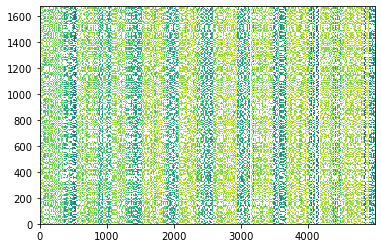

In [16]:
%matplotlib inline
plt.figure()
plt.pcolormesh(np.log10(C_MD))

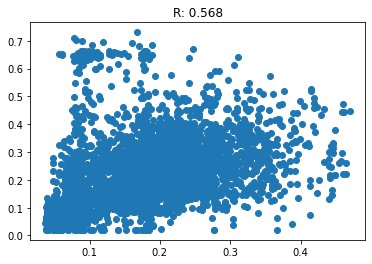

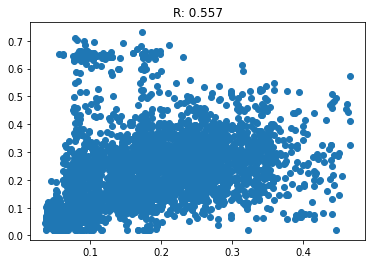

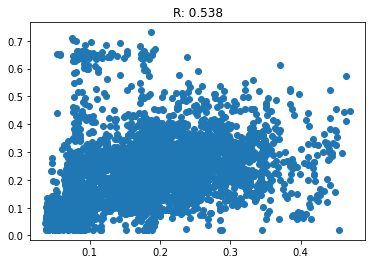

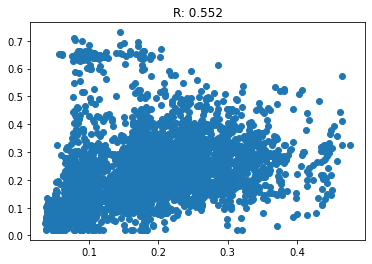

In [46]:
from scipy.stats import pearsonr
for i in range(n_ensemble):
    R = pearsonr(data_measured,data_f[:,i])[0]
    plt.figure()
    plt.plot(data_f[:,i],data_measured,'o')
    plt.title('R: %3.3f' % R)

In [99]:
len(data_measured)

514833

In [87]:
import sys
sys.getsizeof(np.zeros([100000,100000],dtype=np.float16))

data_delta
np.finfo(np.float16)

finfo(resolution=0.001, min=-6.55040e+04, max=6.55040e+04, dtype=float16)

In [88]:
n_param

1677

In [52]:
from scipy import sparse
C_D = 0.1*sparse.eye(len(y_meas),format='csr')

In [54]:
C_D[0:2,0:2].A

array([[0.1, 0. ],
       [0. , 0.1]])

In [19]:
mask_success = np.zeros(n_ensemble)
i_real = 1
for date_results in date_results_iter:
    str_date_results = str(date_results[0].date()).replace('-','') + '-' + str(date_results[-1].date()).replace('-','')
    dir_results = os.path.join(dir_iter,'R%3.3i/run_%s'% (i_real, str_date_results))
    
    files_clm = sorted(glob(os.path.join(dir_results,'clm.clm2.h0.*.nc')))
    dates_TSMP = date_results[1:] #skip the first timestep (= the last timestep of previous run)
    assert len(files_clm) == len(dates_TSMP), 'Something might have gone wrong in realization %i (date %i, iter %i): not every date has a matching file'%(i_real,i_date,i_iter)
    
    

In [5]:
settings_run

{'dir_forcing': '/p/scratch/cjibg36/kaandorp2/data/ERA5_EUR-44_CLM',
 'dir_setup': '/p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/DA_tsmp_cordex_111x108',
 'dir_build': '/p/project/cjibg36/kaandorp2/TSMP_patched/',
 'dir_binaries': '/p/project/cjibg36/kaandorp2/TSMP_patched/bin/JUWELS_3.1.0MCT_clm-pfl',
 'dir_store': None,
 'dir_template': '/p/project/cjibg36/kaandorp2/TSMP_setups/setup_DA_tsmp_cordex_111x108/',
 'spinup': False,
 'init_restart': False,
 'dir_DA': '/p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/DA_tsmp_cordex_111x108/input_DA',
 'dir_iter': '/p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/DA_tsmp_cordex_111x108/20190101-20190131/i000'}

In [28]:
operator.lons_out

{Timestamp('2019-01-04 12:00:00', freq='3D'): array([ 24.693983,  24.787344,  24.880705, ..., -10.596473, -10.503112,
        -10.409751], dtype=float32),
 Timestamp('2019-01-07 12:00:00', freq='3D'): array([ 24.693983 ,  24.787344 ,  24.880705 , ..., -11.810166 ,
        -11.7168045, -11.623444 ], dtype=float32),
 Timestamp('2019-01-10 12:00:00', freq='3D'): array([24.693983  , 24.787344  , 24.880705  , ..., -0.32676348,
        -0.23340249, -0.23340249], dtype=float32),
 Timestamp('2019-01-13 12:00:00', freq='3D'): array([24.600622 , 24.693983 , 24.787344 , ..., -3.1275933, -3.5943983,
        -3.5943983], dtype=float32),
 Timestamp('2019-01-16 12:00:00', freq='3D'): array([27.401453 , 27.961618 , 28.14834  , ..., -6.4885893, -6.8620334,
        -6.8620334], dtype=float32),
 Timestamp('2019-01-19 12:00:00', freq='3D'): array([ 24.693983,  24.787344,  24.880705, ..., -10.036307, -10.129668,
        -10.036307], dtype=float32),
 Timestamp('2019-01-22 12:00:00', freq='3D'): array([ 24.6

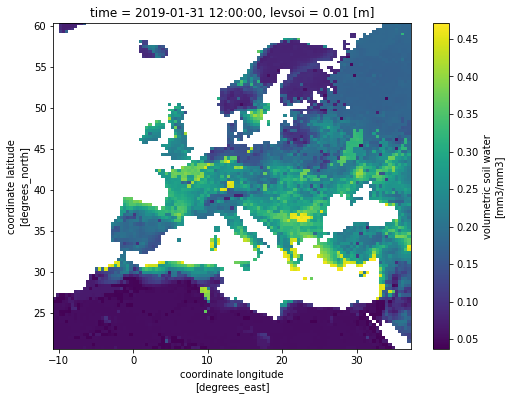

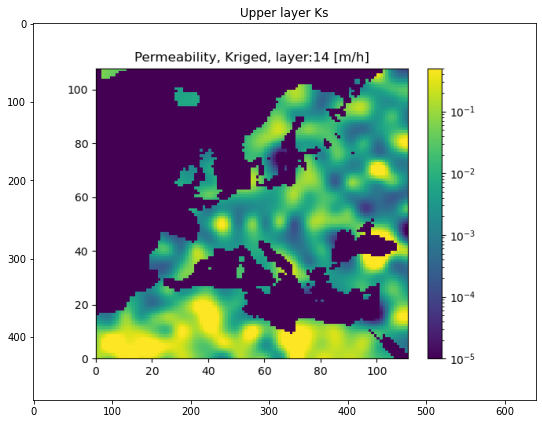

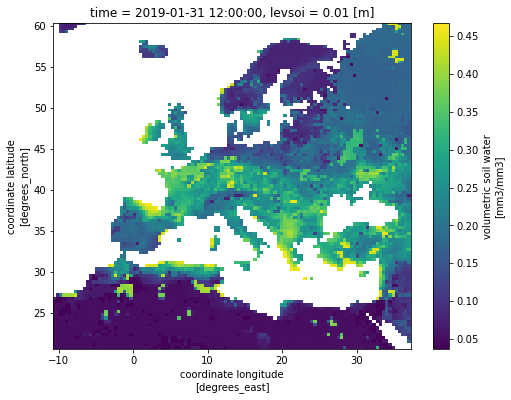

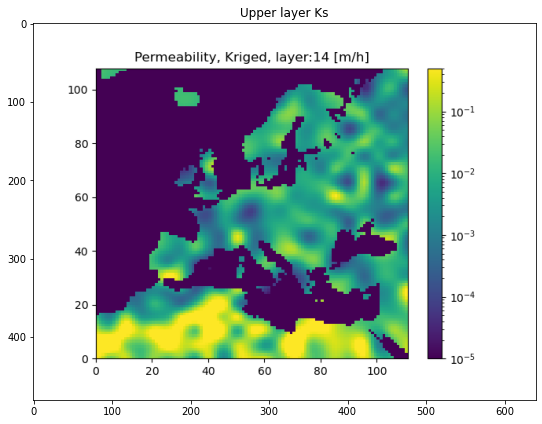

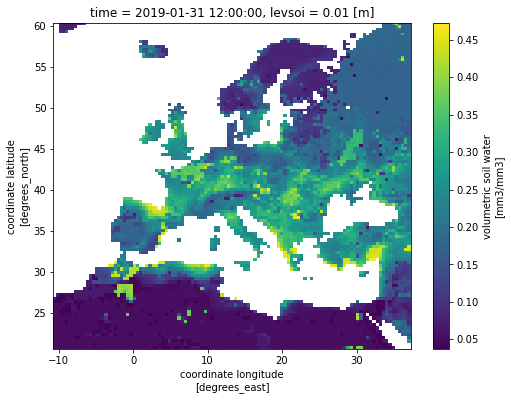

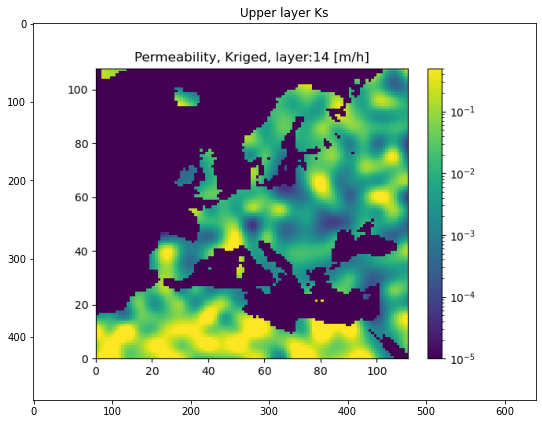

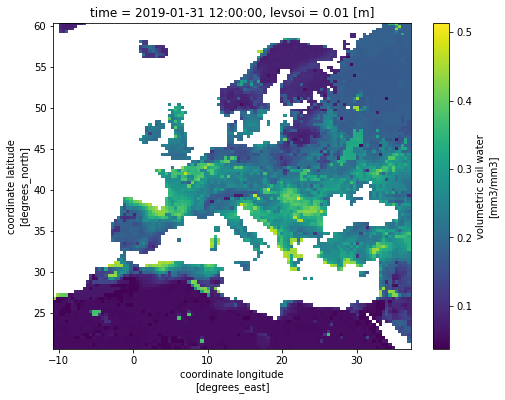

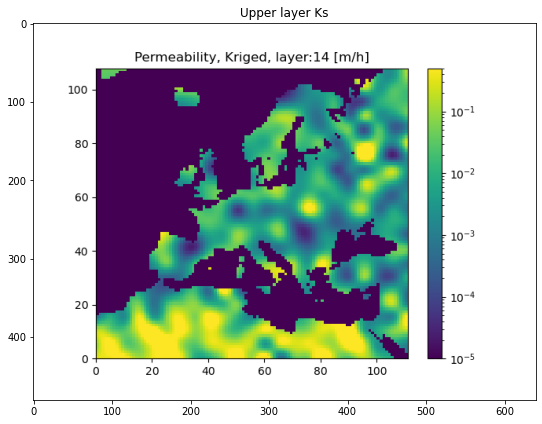

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

figures_Ks = sorted(glob(os.path.join(dir_iter,'**/figures/Ks_real*_014.png')))
data_clm = sorted(glob(os.path.join(dir_iter,'**/**/clm.clm2.h0.2019-01-31-43200.nc'))) 

for i1,data_ in enumerate(data_clm):
    data = xr.open_dataset(data_)
    plt.figure(figsize=(8,6))
    data.H2OSOI[0,0].plot.pcolormesh()

    fig_ = figures_Ks[i1]
    plt.figure(figsize=(9,9))
    image = plt.imread(fig_)
    plt.imshow(image)
    plt.title('Upper layer Ks')
    plt.show()    
    
    

In [36]:
data.H2OSOI

<xarray.DataArray 'H2OSOI' (time: 1, levsoi: 10, lat: 108, lon: 111)>
[119880 values with dtype=float32]
Coordinates:
  * time     (time) object 2019-01-31 12:00:00
  * levsoi   (levsoi) float32 0.01 0.035 0.075 0.135 ... 0.65 1.05 1.65 2.5
  * lon      (lon) float32 -10.5 -10.11 -9.715 -9.32 ... 35.77 36.19 36.62 37.04
  * lat      (lat) float32 20.79 21.19 21.59 21.99 ... 59.3 59.59 59.88 60.17
Attributes:
    long_name:    volumetric soil water
    units:        mm3/mm3
    cell_method:  time: mean

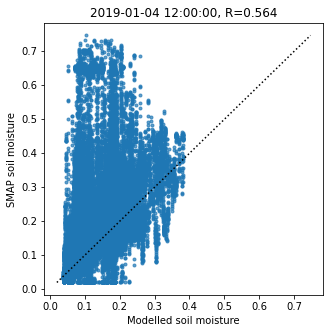

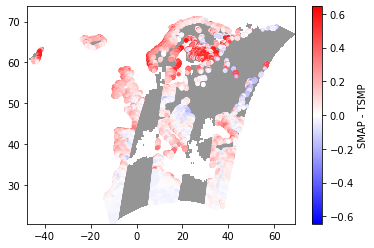

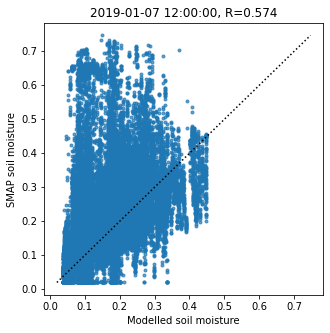

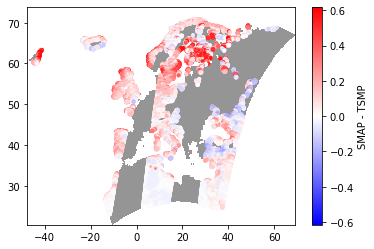

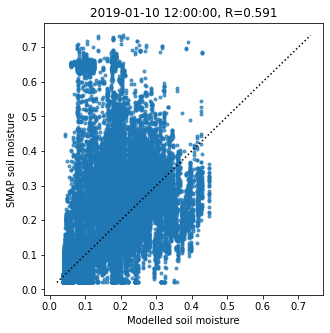

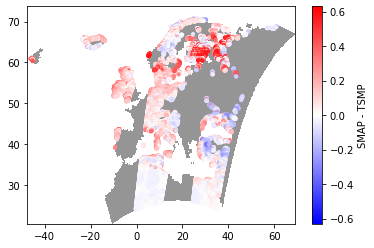

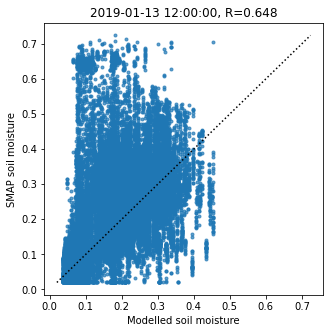

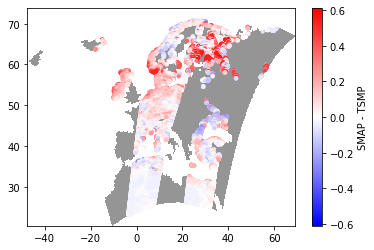

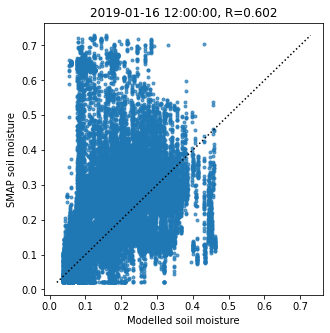

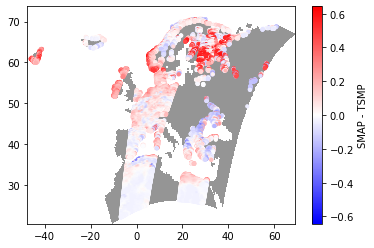

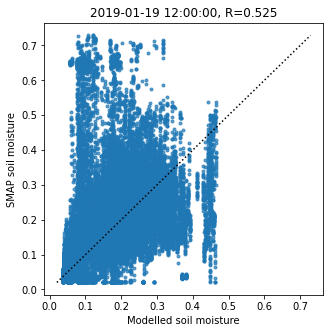

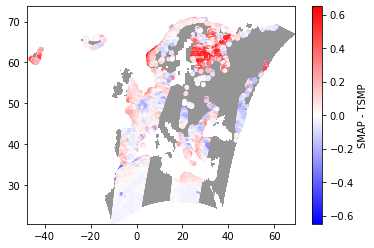

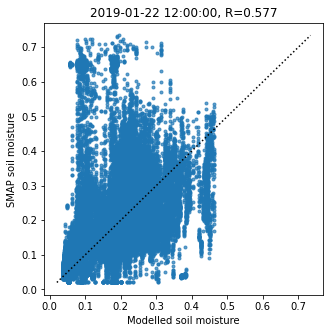

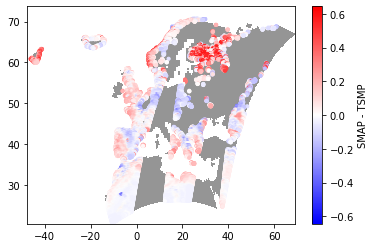

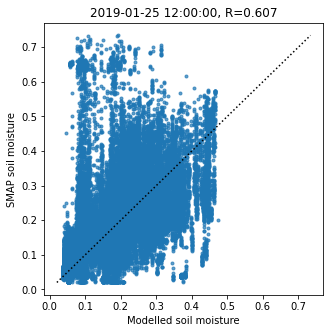

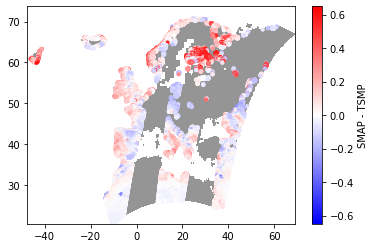

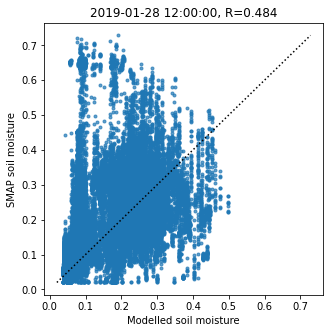

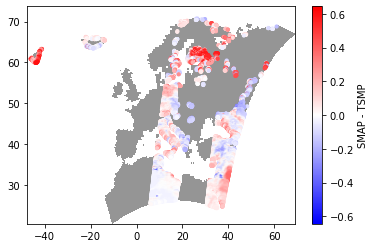

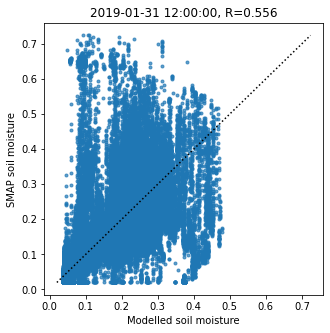

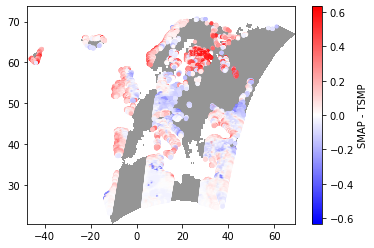

In [29]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline

settings_run['dir_figs']

for date_ in operator.data_TSMP_i.keys():
    
    min_ = min(min(operator.data_TSMP_i[date_]),min(operator.sm_out[date_]))
    max_ = max(max(operator.data_TSMP_i[date_]),max(operator.sm_out[date_]))
    R = pearsonr(operator.data_TSMP_i[date_],operator.sm_out[date_])[0]
    plt.figure(figsize=(5,5))
    plt.plot(operator.data_TSMP_i[date_],operator.sm_out[date_],'o',alpha=.7,markersize=3)
    plt.plot([min_,max_],[min_,max_],'k:')
    plt.xlabel('Modelled soil moisture')
    plt.ylabel('SMAP soil moisture')
    plt.title('%s, R=%3.3f' % (date_,R) )
    
    
    plt.figure()
    plt.pcolormesh(operator.grid_TSMP['lon_corner'],operator.grid_TSMP['lat_corner'],operator.grid_TSMP['lsm']==2,cmap=plt.cm.Greys,vmax=2 )
    diff = operator.sm_out[date_] - operator.data_TSMP_i[date_]
    diff_max = max(np.abs(diff))
    plt.scatter(operator.lons_out[date_],operator.lats_out[date_],s=10,c=diff,vmin=-diff_max,vmax=diff_max,cmap=plt.cm.bwr)
    cbar = plt.colorbar()
    cbar.set_label('SMAP - TSMP')
    

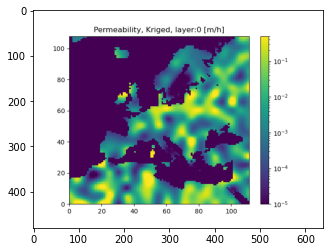

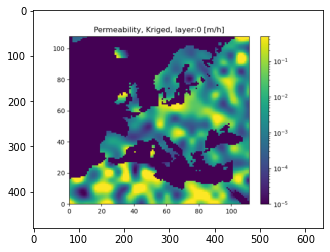

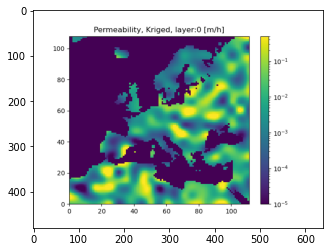

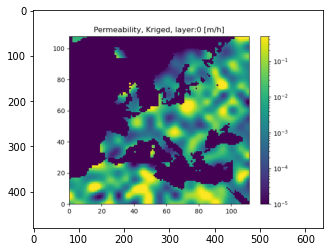

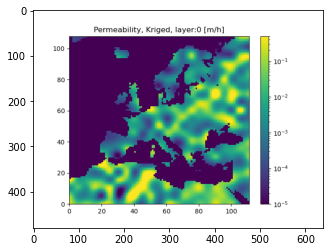

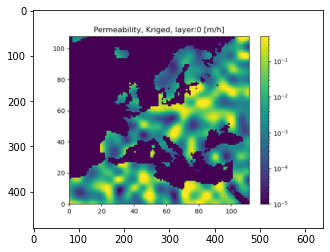

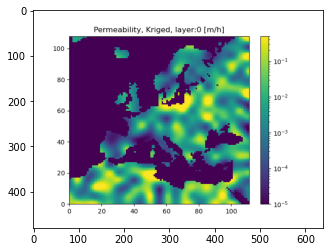

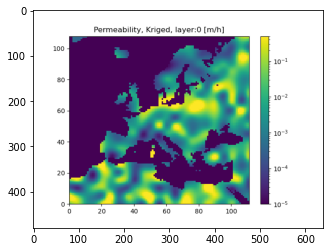

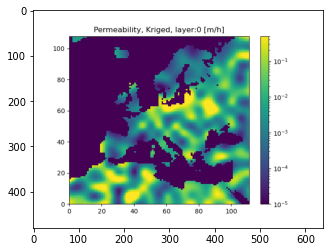

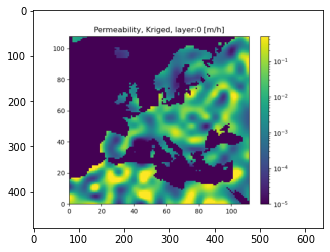

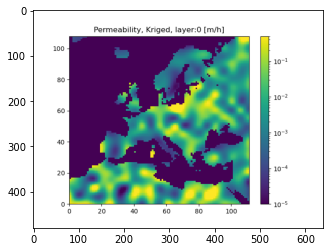

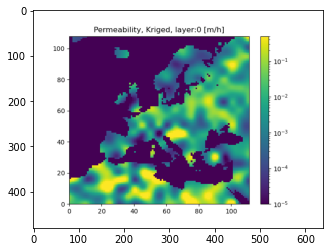

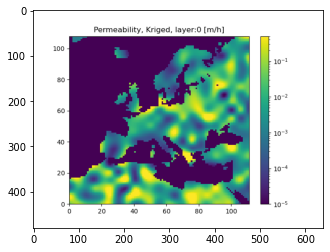

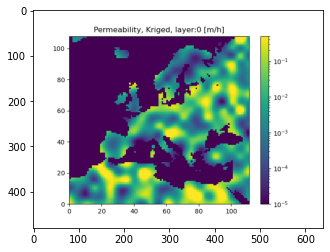

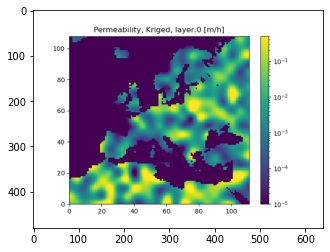

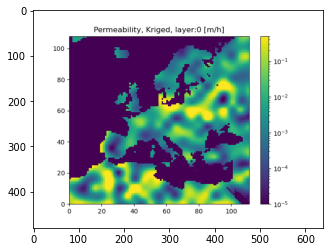

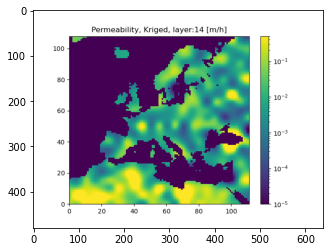

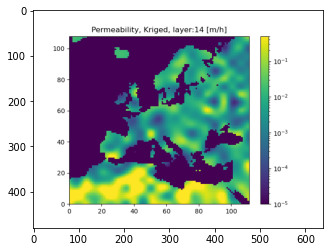

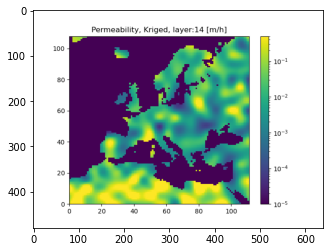

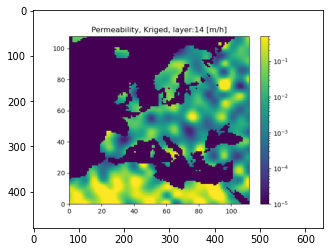

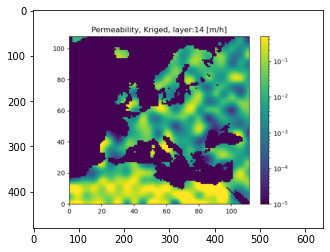

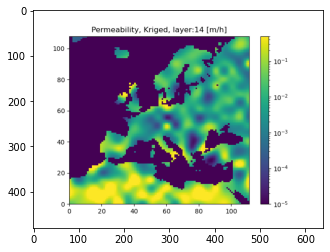

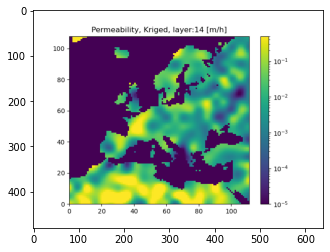

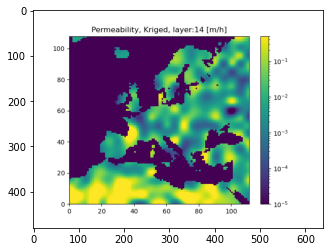

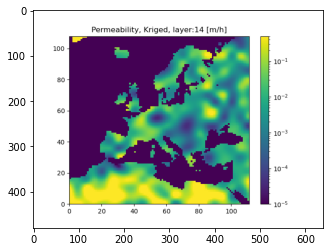

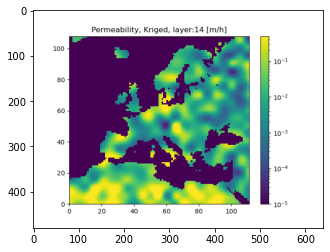

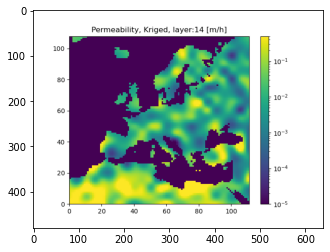

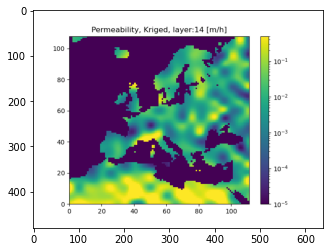

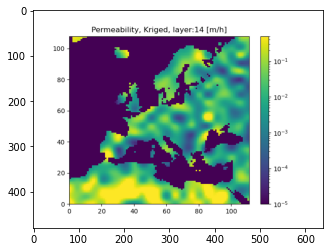

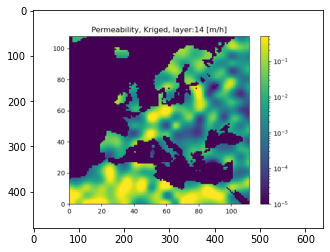

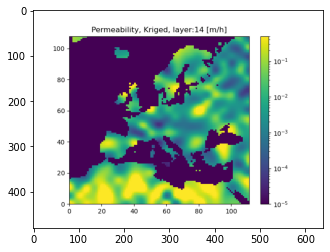

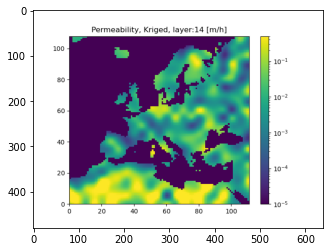

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

figures_Ks = sorted(glob(os.path.join(dir_iter,'**/figures/Ks_real*_000.png')))
for fig_ in figures_Ks:
    plt.figure()
    image = plt.imread(fig_)
    plt.imshow(image)
    plt.show()
    
figures_Ks = sorted(glob(os.path.join(dir_iter,'**/figures/Ks_real*_014.png')))
for fig_ in figures_Ks:
    plt.figure()
    image = plt.imread(fig_)
    plt.imshow(image)
    plt.show()

# figures_Ks

In [27]:
fig_

'/p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/DA_tsmp_cordex_111x108/20190101-20190131/i000/R000/figures/Ks_real000_000.png'

In [ ]:
files = sorted(glob('/p/scratch/cjibg36/kaandorp2/TSMP_results/TSMP_patched/DA_tsmp_cordex_111x108/input_DA/*'))
data1 = np.load(files[1])
data2 = np.load(files[3])

In [34]:
data1

array([-0.37493619,  0.3108977 , -0.82555816, ..., -0.9142631 ,
       -2.23031268, -3.07278167])

In [39]:
data2

array([-0.02403218, -0.3070432 , -1.31746343, ..., -2.13297569,
       -1.8857888 , -2.72254263])